Please read carefully. Ask questions if you are unsure.
=======================================================



We use an auto-grader to check your work. If you invent new notation (such as, new variable names) for yourself, you will mess up the auto-grader and receive no points. We will NOT do manual regrades because of failure to use the requested variable names.



Do not reinitialize variables and data provided for you. Please just run the cells when information is initialized for you. DO NOT RETYPE IT unless it is in a static cell (a cell that has no run button).



Not all tests are visible to you. Just because you have passed a test, doesn’t mean you will get full credit. Take some time to understand what it is your code is doing and what should output so you can check your answers before submission.



Introduction
============



In this project, we will explore how to simulate cloth rapidly. If you have ever played a video game or watched movie with CGI, then **you’ll be excited to learn that the techniques we will implement in this project are widely used to describe the behavior of clothing! :)**



In [1]:
using LinearAlgebra, Plots

Throughout this project, you may find it useful to use the Julia function `LinRange()`. The `LinRange()` function in Julia is used to generate linearly spaced values between a specified start and end value. For instance, if we wanted to create an array of 9 evenly spaced numbers between 51 and 123 (inclusive), then we could write:



In [2]:
LinRange(51, 123, 9)

9-element LinRange{Float64, Int64}:
 51.0, 60.0, 69.0, 78.0, 87.0, 96.0, 105.0, 114.0, 123.0

Task 1: Efficiently Simulating a Simple String
==============================================



In this task, you will model the dynamics of a simple string and use that model to simulate the behavior of the string.



Task 1A: Modeling a Simple String Using Force Balance
-----------------------------------------------------



To start, we will model this string as if it’s made up of a finite number of evenly spaced nodes. We will model the connection between each node of the string by using a spring. Throughout Tasks 1A and 1B, let’s assume that we model the string with 5 nodes. In this case the model would look like this:



![](https://prod-illumidesk-api-media-ueef29.s3.amazonaws.com/campuses/5895ee4e-3555-4b17-9d27-b54bd7098b5c/spring_image_2_1.png)

To explain how the cloth moves, we would use [Newton’s Second Law](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion#Second_law) to describe how forces applied on each node affect the acceleration of each node. For each of the nodes in the center of the string (i.e. when 1<i<5) these equations look like this



m \ddot{x}\_{​i}​=−k(x\_i​−x\_{i−1}-x\_{rest})+k(x\_{i+1}​−x\_{i}-x\_{rest}​)
-----------------------------------------------------------------------------



where \ddot{x}\_i(t) is the acceleration of node i at time t, x\_i(t) is the position of node i at time t, k is the [spring constant](https://en.wikipedia.org/wiki/Hooke%27s_law) that describes how stiff the spring is, x\_{rest} is the resting length of the spring, and m is the mass that we assign to that node. Note that, for convenience we will assume that all of the springs have identical spring constants, and all of the nodes have identical mass. Because Node 1 isn’t connected to any node to its left, its motion can be described by:



m \ddot{x}\_1 = k(x\_2 - x\_1-x\_{rest})
========================================



Throughout this task, we will be trying to compute the motion of the string when it starts from rest and when someone pulls on Node 5. As a result, to describe the motion of Node 5, we can use the following equation:



m \ddot{x}\_5 = -k(x\_5 - x\_4-x\_{rest}) + F\_{ext}
----------------------------------------------------



where F\_{ext} describes the force of the pull that is applied on Node 5. Simulating the model, means that we want to use these previous equations, to predict what the position of the nodes of the string look like as function of time. To do this, **we will approximate the acceleration of each node by using finite difference**:



\ddot{x}\_i(t) \approx \frac{ x\_i(t+1) - 2 x\_i (t) + x\_i(t-1)}{\Delta\_t^2}
==============================================================================



This equation approximates the acceleration of each node at time t by looking at snapshots of the position of the node at different time instances. \Delta\_t describes how far away in time these different snapshots are taken. Note we will set \Delta\_t = 0.01 for the remainder of this project.



Using this finite difference formula, **we can rewrite the prior three equations of motion as follows**:



m \frac{ x\_i(t+1) - 2 x\_i (t) + x\_i(t-1)}{\Delta\_t^2}​=−k(x\_i​(t+1)−x\_{i−1}(t+1)-x\_{rest})+k(x\_{i+1}​(t+1)−x\_{i}(t+1)-x\_{rest}​) for 1< i < 5
-------------------------------------------------------------------------------------------------------------------------------------------------------



m \frac{ x\_1(t+1) - 2 x\_1 (t) + x\_1(t-1)}{\Delta\_t^2} = k(x\_2(t+1) - x\_1(t+1)- x\_{rest}) for i=1
-------------------------------------------------------------------------------------------------------



m\frac{ x\_5(t+1) - 2 x\_5 (t) + x\_5(t-1)}{\Delta\_t^2}= -k(x\_5(t+1) - x\_4(t+1)-x\_{rest}) + F\_{ext}(t+1) for i=5
---------------------------------------------------------------------------------------------------------------------



We can then take these three equations and write it as a set of linear equations as:



A \begin{bmatrix} x\_1(t+1) \\ x\_2(t+1) \\ x\_3(t+1) \\ x\_4(t+1) \\ x\_5(t+1) \end{bmatrix} = b
-------------------------------------------------------------------------------------------------



where the matrix A and vector b have entries that depend on m, k, F\_{ext} and the location of nodes at time t or t-1.



Suppose m=\frac{1}{5}, k=50, \Delta\_t=0.01, x\_{rest}=0.25, F\_{ext}(t) = 1 for all t. In addition, assume the nodes are in the same position at time t as they are in time t-1.



**Build **A** and **b** in this case to mimic the three equations and assume that** x\_i(t) = x\_i (t-1) = 0 **for all** i \in 1, \ldots, 5**.**



In [2]:
k = 50
m = 1/5
delT = 0.01
xRest = 0.25
Fext = 1
temp = m / delT ^ 2 
x_t = zeros(5,1)
x_t_pre = x_t 

A = [temp+k -k 0 0 0;-k temp+2*k -k 0 0;0 -k temp+2*k -k 0;
  0 0 -k temp+2*k -k;0 0 0 -k temp+k]
b = 2*temp*x_t - temp*x_t_pre + [- k*xRest ;0;0;0; k*xRest + Fext]

5×1 Matrix{Float64}:
 -12.5
   0.0
   0.0
   0.0
  13.5

Task 1B: Simulating the Simple String
-------------------------------------



To simulate the simple string, we can recursively solve A \begin{bmatrix} x\_1(t+1) \\ x\_2(t+1) \\ x\_3(t+1) \\ x\_4(t+1) \\ x\_5(t+1) \end{bmatrix} = b repeatedly. That is, if we knew x\_i(t) for all t\leq 0 and for each i, then we could use the



linear equation to solve for x\_i(1) for each i and then use that solution to solve for x\_i(2) for each i and so on.



Suppose m=\frac{1}{5}, k=50, \Delta\_t = 0.01, F\_{ext}(t) = 1 for all t \geq 0, and let the left end of the string be at 0 and the right end of the string is at 1. The string does not move for any t<0.



**Compute** X\_0 := \begin{bmatrix} x\_1(0) \\ x\_2(0) \\ x\_3(0) \\ x\_4(0) \\ x\_5(0) \end{bmatrix} and save the result in a vector called `X0`.



In [5]:
X0 = LinRange(0,1,5)
@show X0

X0 = LinRange{Float64}(0.0, 1.0, 5)


5-element LinRange{Float64, Int64}:
 0.0, 0.25, 0.5, 0.75, 1.0

Next compute x\_i(t) for each i and 0 \leq t \leq 100. Save the result in a matrix called X where column j corresponds to the position of the nodes at time j-1. Please use the `inv()` Julia function to compute the inverse.



In [7]:
X = zeros(5,101)

# Position of nodes at t=0
X[:,1] = X0

# Positions of nodes at t=1
x_t = X0
x_t_pre = X0 # Position at t = -1 is the same as X0

# Postitions of nodes from t=2 to t=100
for i = 2:101
  b = 2*temp*x_t - temp*x_t_pre + [- k*xRest ;0;0;0; k*xRest + Fext]
  X[:,i] = inv(A)*b   # Positions of nodes at t
  x_t = X[:,i]          # Positions of nodes at t-1 for next loop
  x_t_pre = X[:,i-1]    # Positions of nodes at t-2 for next loop
end


Task 1C: Increasing the Number of Nodes
---------------------------------------



You can use the following code to visualize what the result looks like from the previous simulation.



┌ Info: Saved animation to C:\Users\user\AppData\Local\Temp\jl_TIX2vKXwxM.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\user\\AppData\\Local\\Temp\\jl_TIX2vKXwxM.gif")
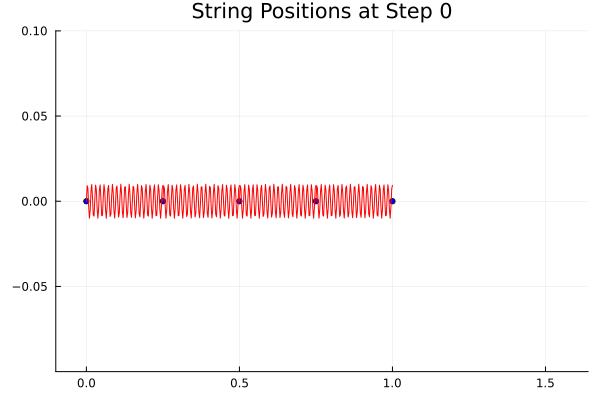

In [8]:
# Determine fixed x-axis limits
x_min = minimum(X)
x_max = maximum(X)

# Plotting function
function plot_spring_system(positions, step, x_min, x_max)
    n = size(positions, 1)
    plot(title="String Positions at Step $step",
         legend=false, ylims=(-0.1, 0.1), xlims=(x_min - 0.1, x_max + 0.1))
    scatter!(positions, zeros(n), color=:blue, marker=:circle, ms=3)  # Plot nodes
    for i in 1:n-1
        # Draw spring as a series of small segments
        spring_x = [positions[i] + (positions[i+1]-positions[i]) * j/100 for j in 0:100]
        spring_y = [0.01*sin(20*j) for j in 0:100]
        plot!(spring_x, spring_y, seriestype=:path, color=:red, lw=1)
    end
end

# Create an animation
num_steps = 100
animation = @animate for t in 1:num_steps+1
    plot_spring_system(X[:, t], t-1, x_min, x_max)
end

# Display the animation without saving it to a file
gif(animation, fps=10)

To make simulations look more realistic, engineers usually introduce more nodes to describe the same string.



Use 1000 nodes to describe the string. In this case, m= \frac{1}{1000}, k = \frac{24975}{2}, \Delta\_t = 0.01, x\_{rest}= \frac{1}{999}, and F\_{ext} = 1 for all t\geq 0. Build A, b, X\_0, and X for this case. Be aware that it may take a long time to run.



┌ Info: Saved animation to C:\Users\user\AppData\Local\Temp\jl_Lul4TUvEx6.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\user\\AppData\\Local\\Temp\\jl_Lul4TUvEx6.gif")
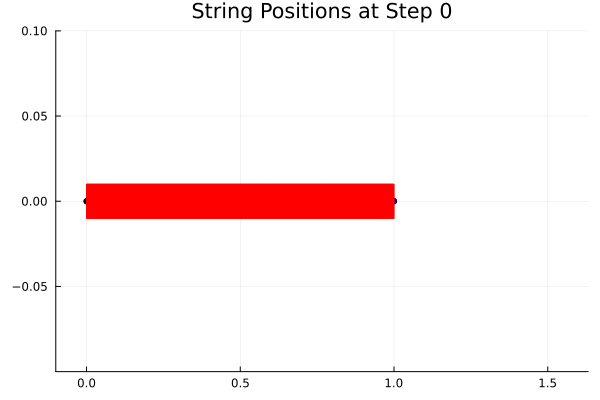

In [11]:
# Setting matrix A and B

k = 24975/2
m = 1/1000
delT = 0.01
xRest = 1/999
Fext = 1
temp = m / delT ^ 2 
X0 = LinRange(0,1,1000)
x_t = X0
x_t_pre = X0


A = zeros(1000,1000)
for i = 1:1000
  if i == 1
    A[i,1] = temp + k
    A[i,2] = -k
  elseif i == 1000
    A[i,999] = -k
    A[i,1000] = temp+k
  else
    A[i,i] = temp+2*k
    A[i,i-1] = -k
    A[i,i+1] = -k
  end
end

# Determine the location of nodes in different time
X = zeros(1000,101)
X[:,1] = X0

for i = 2:101
  b = collect(2*temp*x_t - temp*x_t_pre)
  b[1] = b[1] - k*xRest
  b[1000] = b[1000] + k*xRest + Fext
  X[:,i] = inv(A)*b   # Positions of nodes at t
  x_t = X[:,i]          # Positions of nodes at t-1 for next loop
  x_t_pre = X[:,i-1]    # Positions of nodes at t-2 for next loop
end

# Determine fixed x-axis limits
x_min = minimum(X)
x_max = maximum(X)

# Create an animation
num_steps = 100
animation = @animate for t in 1:num_steps+1
    plot_spring_system(X[:, t], t-1, x_min, x_max)
end

# Display the animation without saving it to a file
gif(animation, fps=10)


Task 1D: Improving Computational Speed by Using LU factorization
----------------------------------------------------------------



You may have noticed that it took a long time to simulate this model. Let’s improve the computation by making several observations. First, notice that `A` does not change during the simulation. As a result, we do not need to invert it over and over again. Second, notice that if we apply the LU factorization on `A` once, then we can just apply forward and backward substitution to simulate the model rapidly. Compute X rapidly by using these observations.



In [14]:
# Setting matrix A and B

k = 24975/2
m = 1/1000
delT = 0.01
xRest = 1/999
Fext = 1
temp = m / delT ^ 2 
X0 = LinRange(0,1,1000)
x_t = X0
x_t_pre = X0


A = zeros(1000,1000)
for i = 1:1000
  if i == 1
    A[i,1] = temp + k
    A[i,2] = -k
  elseif i == 1000
    A[i,999] = -k
    A[i,1000] = temp+k
  else
    A[i,i] = temp+2*k
    A[i,i-1] = -k
    A[i,i+1] = -k
  end
end

# Forward and backward substitution functions
function backwardsub(U, b)
  n = length(b)
  x = Vector{Float64}(undef, n) 
  x[n] = b[n]/U[n,n]
  for i in n-1:-1:1
      x[i]=(b[i]- (U[i,(i+1):n])' *x[(i+1):n] )./U[i,i]
  end
  return x
end

function forwardsub(L, b)
  n = length(b)
  x = Vector{Float64}(undef, n); 
  x[1] = b[1]/L[1,1] 
  for i = 2:n 
      x[i]=(b[i]- (L[i,1:i-1])' *x[1:i-1] )./L[i,i] 
  end
  return x
end

# LU factorization and first two positions t=0 and t=1
F = lu(A);
X = zeros(1000,101);
X[:,1] = X0;

# Loop
for i = 2:101
  b = collect(2*temp*x_t - temp*x_t_pre)
  b[1] = b[1] - k*xRest
  b[1000] = b[1000] + k*xRest + Fext
  Y = forwardsub(F.L, b)
  X[:,i] = backwardsub(F.U,Y)   # Positions of nodes at t
  x_t = X[:,i]          # Positions of nodes at t-1 for next loop
  x_t_pre = X[:,i-1]    # Positions of nodes at t-2 for next loop
end

#@show X[1:10,2]

┌ Info: Saved animation to C:\Users\user\AppData\Local\Temp\jl_pARM94Lc3I.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\user\\AppData\\Local\\Temp\\jl_pARM94Lc3I.gif")
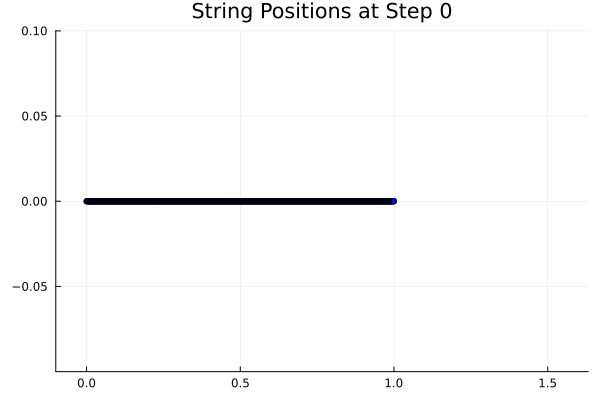

In [15]:
# Determine fixed x-axis limits
x_min = minimum(X)
x_max = maximum(X)

# Plotting function
function plot_spring_system(positions, step, x_min, x_max)
    n = size(positions, 1)
    plot(title="String Positions at Step $step",
         legend=false, ylims=(-0.1, 0.1), xlims=(x_min - 0.1, x_max + 0.1))
    scatter!(positions, zeros(n), color=:blue, marker=:circle, ms=3)  # Plot nodes
end

# Create an animation
animation = @animate for t in 1:num_steps+1
    plot_spring_system(X[:, t], t-1, x_min, x_max)
end

# Display the animation without saving it to a file
gif(animation, fps=10)

Task 2: Efficiently Simulating a Cloth
======================================



We are now going to generalize from simulating a string to simulating a cloth. In the string case, we were only interested in understanding the behavior of the string in 1 dimension. As a result, we described the behavior of the string by using a set of nodes in 1 dimension and describing the dynamics of each node along that 1 dimension. To simulate a cloth, we will use nodes in 2 dimensions and describe how Hooke’s law behaves affects the behavior of each node along each dimension.



Throughout this task, we will assume we have 10 nodes along each dimension. Suppose the cloth is a square that is laid out between 0 and 1 in the horizontal and vertical directions and is at rest for all t \leq 0. In this case, the model would look like this:



![](https://prod-illumidesk-api-media-ueef29.s3.amazonaws.com/campuses/5895ee4e-3555-4b17-9d27-b54bd7098b5c/spring_image_4.png)

Now, each node, r\_{i,j}, has a component x\_{i,j} along the horizontal direction and has a component y\_{i,j} along the vertical direction for each 1 \leq i,j \leq 10. For each node in the center of the cloth (i.e. 1 < i,j < 10), we can describe the behavior as:'



m\ddot{x}\_{i,j} = -k(x\_{i,j} - x\_{i-1,j} - x\_{rest}) + k(x\_{i+1,j}-x\_{i,j} - x\_{rest}) - k (x\_{i,j}-x\_{i,j-1} )+ k(x\_{i,j+1} - x\_{i,j})
--------------------------------------------------------------------------------------------------------------------------------------------------



m\ddot{y}\_{i,j} = -k(y\_{i,j} - y\_{i-1,j} ) + k(y\_{i+1,j}-y\_{i,j} ) - k (y\_{i,j} - y\_{i,j-1}-y\_{rest}) + k(y\_{i,j+1} - y\_{i,j}-y\_{rest})
--------------------------------------------------------------------------------------------------------------------------------------------------



One can define the equations for the boundary nodes similarly. Note in this case, suppose we only apply an external force, F\_{ext}(t) = 1 for all t\geq0, in the vertical direction to node r\_{10,10}. Recall that this node is located at the position (1,1). One can then apply the same finite difference formula as in Task 1, and then write down a system of linear equations:



A \begin{bmatrix} x\_{1,1}(t+1) \\ y\_{1,1}(t+1) \\ x\_{1,2}(t+1) \\ y\_{1,2}(t+1) \\ \vdots \\ x\_{1,5}(t+1) \\ y\_{1,5}(t+1) \\ x\_{2,1}(t+1) \\ y\_{2,1}(t+1) \\ \vdots \\ y\_{10,10}(t+1) \end{bmatrix} = b
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



Suppose the nodes are evenly spaced in each direction. Suppose



R\_t = \begin{bmatrix} x\_{1,1}(t) \\ y\_{1,1}(t) \\ x\_{1,2}(t) \\ y\_{1,2}(t) \\ \vdots \\ x\_{1,10}(t) \\ y\_{1,10}(t) \\ x\_{2,1}(t) \\ y\_{2,1}(t) \\ \vdots \\ y\_{10,10}(t) \end{bmatrix}
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



Let’s use the following constants:



In [16]:
# Parameters
n = 10  # Grid size (n x n)
num_nodes = n * n
mass = 1.0 / num_nodes
k = 10.0
dt = 0.01
num_steps = 100
x_rest = 1.0 / (n - 1)
y_rest = 1.0 / (n - 1)

0.1111111111111111

Compute R\_0 and save the result in a vector called `R0`.



In [17]:
X0 = LinRange(0,1,n);
Y0 = LinRange(0,1,n);
R0 = Vector{Float64}(undef, 2*num_nodes);

# in ith row
for i = 1:n
  # in jth column
  for j = 1:n
    R0[2*n*(i-1)+2*j-1] = X0[j];
    R0[2*n*(i-1)+2*j] = Y0[i];
  end
end

Compute R\_t for each 0\leq t \leq 100. Save the result in a matrix R whose k^{th} column corresponds to R\_k.



In [18]:
Fext = 1;
temp = mass / dt ^ 2 ;
r_t = R0 
r_t_pre = R0

# Setting matrix A and b
A = zeros(2*num_nodes,2*num_nodes);

for i = 1:n # ith row node
  for j = 1:n # jth column node
    # coordinates of x,y
      coordX = 2*n*(i-1)+2*j-1;
      coordY = 2*n*(i-1)+2*j;
    
    if i==1
      if j==1
        # x node (1,1) at index 1
        A[coordX,coordX] = temp + 2*k;
        A[coordX,coordX+2] = -k; # x node (1,2) at index 3

        # y node (1,1) at index 2
        A[coordY,coordY] = temp + 2*k;
        A[coordY,coordY+2] = -k; # y node (1,2) at index 4
        
      elseif j ==n
        # x node (1,10) at index 19
        A[coordX,coordX] = temp + 2*k;
        A[coordX,coordX-2] = -k; # x node (1,9) at index 17

        # y node (1,10) at index 20
        A[coordY,  coordY] = temp + 2*k;
        A[coordY,  coordY-2] = -k; # y node (1,9) at index 18
        
      else
        # x node (1,j) at index 2j-1
        A[coordX,coordX] = temp + 3*k;
        A[coordX,coordX-2] = -k; # x node (1,j-1)
        A[coordX,coordX+2] = -k; # x node (1,j+1)

        # y node (1,j) at index 2j
        A[coordY, coordY] = temp + 3*k;
        A[coordY, coordY-2] = -k; # y node (1,j-1) 
        A[coordY, coordY+2] = -k; # y node (1,j+1)
        
      end
      
      A[coordX,coordX+20] = -k;       # x node (2,j)
      A[coordY,  coordY+20] = -k;         # y node (2,j)
      
    elseif i ==n
      if j==1
        # x node (10,1) at index 181
        A[coordX, coordX] = temp + 2*k;
        A[coordX, coordX+2] = -k; # x node (10,2) at index 183

        # y node (10,1) at index 182
        A[coordY, coordY] = temp + 2*k;
        A[coordY, coordY+2] = -k; # y node (10,2) at index 184
        
      elseif j ==n
        # x node (10,10) at index 199
        A[coordX, coordX] = temp + 2*k;
        A[coordX, coordX-2] = -k; # x node (10,9) at index 197

        # y node (10,10) at index 200
        A[coordY, coordY] = temp + 2*k;
        A[coordY, coordY-2] = -k; # y node (10,9) at index 198
        
      else
        # x node (10,j) at index 2j-1
        A[coordX, coordX] = temp + 3*k;
        A[coordX, coordX-2] = -k; # x node (10,j-1)
        A[coordX, coordX+2] = -k; # x node (10,j+1)    

        # y node (10,j) at index 2j
        A[coordY, coordY] = temp + 3*k;
        A[coordY, coordY-2] = -k; # y node (10,j-1) 
        A[coordY, coordY+2] = -k; # y node (10,j+1)
        
      end
      
      A[coordX, coordX-20] = -k;       # x node (9,j)
      A[coordY, coordY-20] = -k;         # y node (9,j)
    
    else
      if j==1
        # x node (i,1) at index 20(i-1)+1
        A[coordX, coordX] = temp + 3*k;
        A[coordX, coordX+2] = -k; # x node (i,2) 

        # y node (i,1) at index 20(i-1)+2
        A[coordY, coordY] = temp + 3*k;
        A[coordY, coordY+2] = -k; # y node (i,2)
        
      elseif j ==n
        # x node (i,10) at index 20(i-1)+1
        A[coordX, coordX] = temp + 3*k;
        A[coordX, coordX-2] = -k; # x node (i,9) at index 197

        # y node (i,10) at index 20(i-1)+2
        A[coordY, coordY] = temp + 3*k;
        A[coordY, coordY-2] = -k; # y node (i,9) at index 198
        
      else
        # x node (i,j) at index 2j-1
        A[coordX, coordX] = temp + 4*k;
        A[coordX, coordX-2] = -k; # x node (i,j-1)
        A[coordX, coordX+2] = -k; # x node (i,j+1)

        # y node (i,j) at index 2j
        A[coordY, coordY] = temp + 4*k;
        A[coordY, coordY-2] = -k; # y node (i,j-1) 
        A[coordY, coordY+2] = -k; # y node (i,j+1)
        
      end
      
      A[coordX, coordX+20] = -k;       # x node (i+1,j)
      A[coordY, coordY+20] = -k;         # y node (i+1,j)
      A[coordX, coordX-20] = -k;       # x node (i-1,j)
      A[coordY, coordY-20] = -k;         # y node (i-1,j)
      
    end   
  end
end

# LU factorization and first two positions t=0 and t=1
F = lu(A);
R = zeros(2*num_nodes,101);
R[:,1] = R0;

# Loop
for p = 2:num_nodes+1

  b = collect(2*temp*r_t - temp*r_t_pre)
  for i = 1:n # ith row node
    for j = 1:n # jth column node
      # coordinates of x,y
      coordX = 2*n*(i-1)+2*j-1;
      coordY = 2*n*(i-1)+2*j;

      # for x components
      if j==1
        b[coordX] = b[coordX] - k*x_rest; 
      
      elseif j ==n
        b[coordX] = b[coordX] + k*x_rest;
    
      else
        b[coordX] = b[coordX];  
      end

      # for y components
      if i==1      
        b[coordY] = b[coordY]-k*y_rest;
        
      elseif i ==n
        if j ==n
          b[coordY] = b[coordY]+Fext;
        end
        b[coordY] = b[coordY]+k*y_rest
        
      else
        b[coordY] = b[coordY];
        
      end
    end

  Y = forwardsub(F.L, b)
  R[:,p] = backwardsub(F.U,Y)   # Positions of nodes at t
  r_t = R[:,p]        # Positions of nodes at t-1 for next loop
  r_t_pre = R[:,p-1]  # Positions of nodes at t-2 for next loop

  end
end

Here is some code to visualize your solution!



┌ Info: Saved animation to C:\Users\user\AppData\Local\Temp\jl_9ozejmbuzQ.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\user\\AppData\\Local\\Temp\\jl_9ozejmbuzQ.gif")
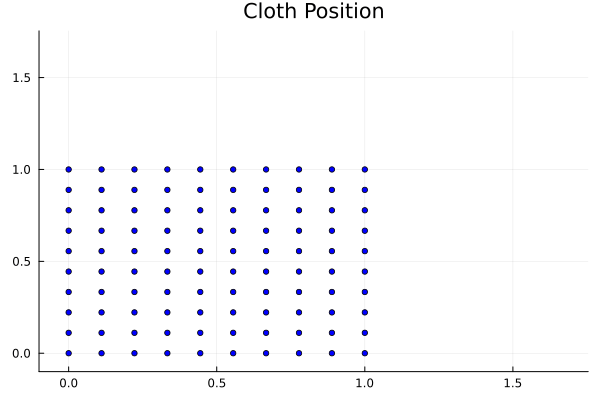

In [19]:
r_min = minimum(R)
r_max = maximum(R)

# Plotting function
function plot_cloth(positions, n, r_min, r_max)
  plot(title="Cloth Position",
         legend=false, ylims= (r_min-0.1,r_max+0.1), xlims = (r_min-0.1,r_max+0.1))
    scatter!(positions[:, 1], positions[:, 2], color=:blue, marker=:circle, ms=3)
    
end

# Create an animation
animation = @animate for t in 1:num_steps+1
  positions = zeros(num_nodes, 2)
  for i in 1:num_nodes
    positions[i, 1] = R[2*i-1,t]
    positions[i, 2] = R[2*i, t]
  end
  plot_cloth(positions, n, r_min, r_max)
end

# Display the animation without saving it to a file
gif(animation, fps=10)

![](https://prod-illumidesk-api-media-ueef29.s3.amazonaws.com/campuses/5895ee4e-3555-4b17-9d27-b54bd7098b5c/MissionPassed.png)